In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
csv_file = "2025-02-19_16-44-43_metr-la_pred-15min_his-60min_centralized_analysis-neighbours-and-no-neighbours/val_metric/delta.csv"

__file__ = "/leonardo_work/EUHPC_D12_053/stgcn-distributed/script/analyze_error_csv.py"

script_dir = os.path.dirname(os.path.abspath(__file__))
base_dir = os.path.abspath(os.path.join(script_dir, os.pardir))

path = os.path.join(base_dir, 'logs', csv_file)
print(f"Processing: {path}")

df = pd.read_csv(path, header=None)  # Assuming no headers
df = df.T

# df = df.iloc[:10,:100]
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

df_long = df.melt(value_vars=df.columns, ignore_index=False)
df_long = df_long.reset_index()
df_long = df_long.rename(columns={"index": "sensorId", "variable": "timestep", "value": "predictionDelta"})
df_long.head(20)

Processing: /leonardo_work/EUHPC_D12_053/stgcn-distributed/logs/2025-02-19_16-44-43_metr-la_pred-15min_his-60min_centralized_analysis-neighbours-and-no-neighbours/val_metric/delta.csv
Rows: 207, Columns: 5125


,sensorId,timestep,predictionDelta
0,0,0,1.242699
1,1,0,0.901730
2,2,0,-2.085411
3,3,0,-1.924915
4,4,0,0.597954
5,5,0,1.031860
6,6,0,-0.953487
7,7,0,1.066364
8,8,0,0.316444
9,9,0,0.009201


In [4]:
# Flatten the DataFrame and get the top 10 highest values with their indices
stacked = df.stack()
top_10 = stacked.nlargest(10)

# Output results in the requested format
for (sensor_id, datastep), value in top_10.items():
    print(f"SensorId: {sensor_id} | {datastep}: {value}")

SensorId: 59 | 4: 36.094425201416016
SensorId: 163 | 474: 34.957134246826165
SensorId: 59 | 3: 30.343212127685543
SensorId: 24 | 474: 29.144142150878903
SensorId: 127 | 474: 27.423080444335938
SensorId: 159 | 474: 27.418746948242188
SensorId: 95 | 3758: 27.315814971923828
SensorId: 85 | 499: 27.170135498046875
SensorId: 59 | 5: 26.940263748168945
SensorId: 157 | 474: 26.761341094970703


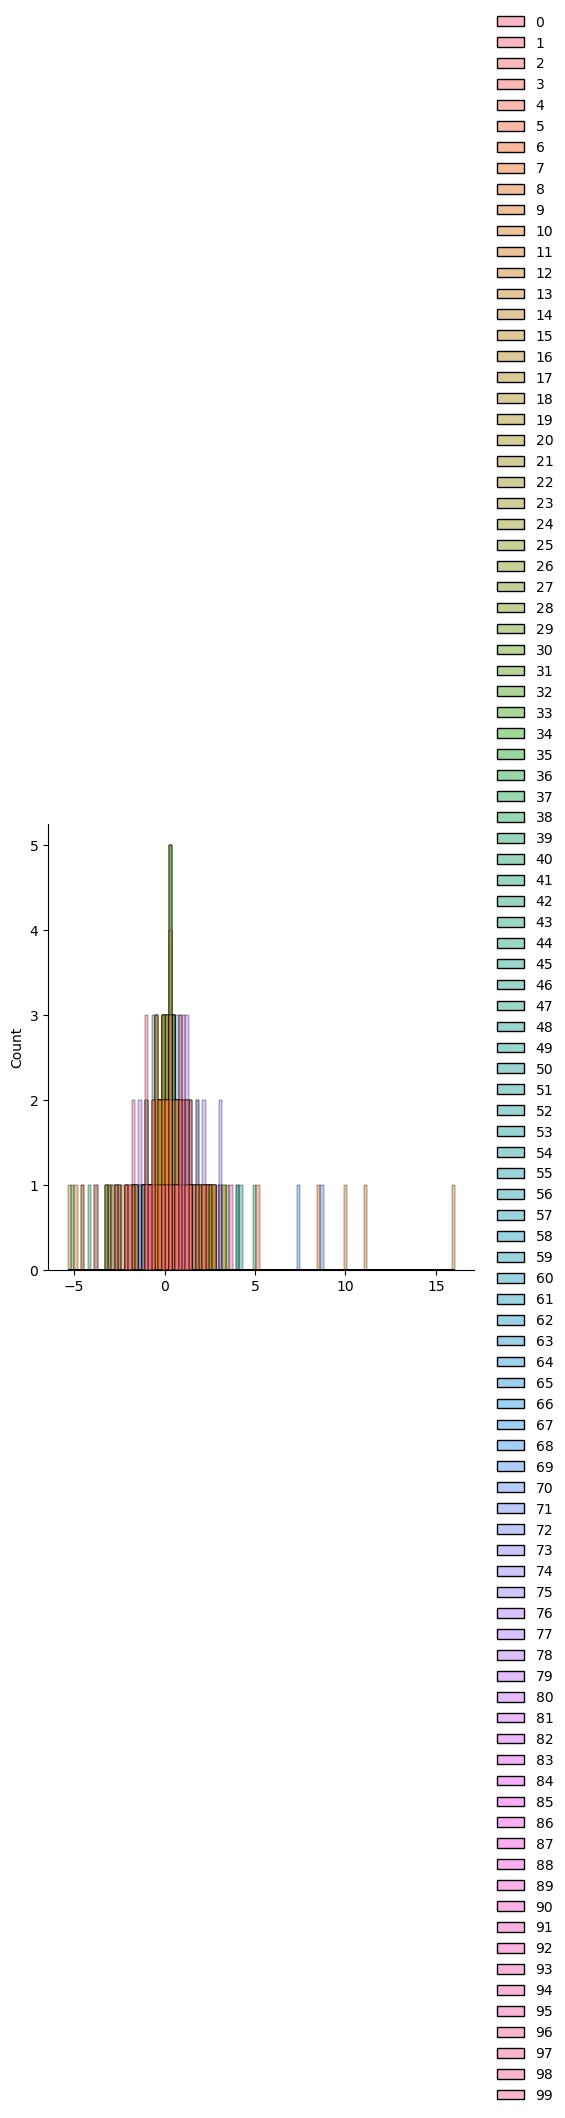

In [ ]:
plt.close()
sns.displot(data=df)

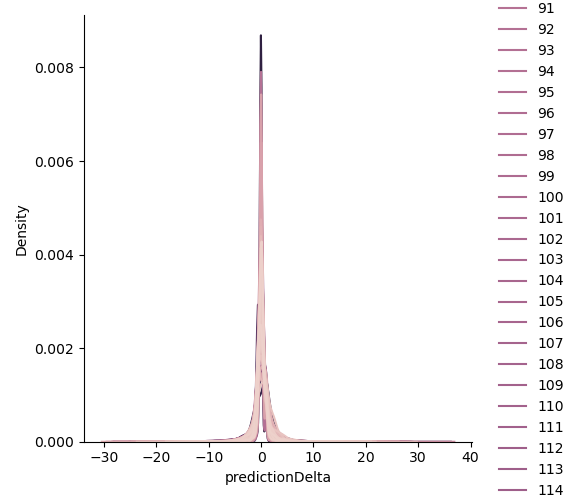

In [24]:
plt.close()
sns.displot(data=df_long, x="predictionDelta", hue="sensorId", kind="kde")

<Axes: xlabel='timestep', ylabel='predictionDelta'>

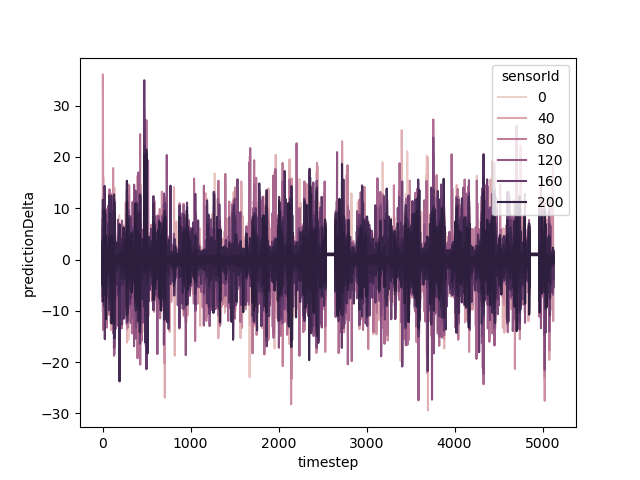

In [4]:
plt.close()
sns.lineplot(data=df_long, y="predictionDelta", x="timestep", hue="sensorId")

In [5]:
df_long.predictionDelta.mean()

0.037359551869447796

In [13]:
df_long_rolling = df_long.groupby('sensorId').rolling(12, on="timestep").mean()
df_long_rolling.head(20)

timestep  abs_predictionDelta  predictionDelta
sensorId                                                     
0        0            0                  NaN              NaN
         207          1                  NaN              NaN
         414          2                  NaN              NaN
         621          3                  NaN              NaN
         828          4                  NaN              NaN
         1035         5                  NaN              NaN
         1242         6                  NaN              NaN
         1449         7                  NaN              NaN
         1656         8                  NaN              NaN
         1863         9                  NaN              NaN
         2070        10                  NaN              NaN
         2277        11             0.816115         0.445148
         2484        12             0.730586         0.359619
         2691        13             0.668690         0.260751
         2898        14             0.597468         0.181852
         3105        15             0.540198         0.124581
         3312        16             0.497270         0.226923
         3519        17             0.415147         0.133716
         3726        18             0.372407         0.090975
         3933        19             0.327406         0.045974

In [22]:
df_high_error = df_long.groupby("timestep")["predictionDelta"].mean()
df_high_error = df_high_error[df_high_error > df_high_error.quantile(0.95)]  # Top 5% highest errors
df_high_error.sort_values(ascending=False)

timestep
474     6.008415
3763    5.959413
3762    5.330793
497     5.216723
2529    4.776463
          ...   
2607    0.987584
4937    0.987584
4960    0.987584
2627    0.987584
4873    0.987584
Name: predictionDelta, Length: 257, dtype: float64

In [23]:
df_low_error = df_long.groupby("timestep")["predictionDelta"].mean()
df_low_error = df_low_error[df_low_error < df_low_error.quantile(0.05)]  # Bottom 5% lowest errors
df_low_error.sort_values(ascending=True)  # Sort from lowest to highest

timestep
3143   -4.622648
2788   -4.600391
3765   -4.481770
3327   -4.461645
3144   -4.381926
          ...   
3482   -0.349217
4571   -0.349164
4022   -0.348661
3332   -0.348222
4574   -0.347727
Name: predictionDelta, Length: 257, dtype: float64

In [9]:
df_sensor_error = df_long.groupby("sensorId")["predictionDelta"].mean()
df_sensor_error = df_sensor_error[df_sensor_error > df_sensor_error.quantile(0.95)]
df_sensor_error

sensorId
12     0.399400
16     0.701964
29     0.408654
51     0.212236
56     0.283104
70     0.297904
71     0.267335
144    0.290665
183    0.211805
196    0.553187
197    0.361831
Name: predictionDelta, dtype: float64

In [12]:
df_high_pairs = df_long[df_long['predictionDelta'] > df_long['predictionDelta'].quantile(0.95)]
df_high_pairs

,sensorId,timestep,predictionDelta,abs_predictionDelta
10,10,0,2.683750,2.683750
23,23,0,2.446114,2.446114
25,25,0,3.132833,3.132833
32,32,0,5.183506,5.183506
36,36,0,2.518044,2.518044
...,...,...,...,...
1059623,197,5118,2.292465,2.292465
1059695,62,5119,9.895012,9.895012
1059902,62,5120,5.584660,5.584660
1060109,62,5121,2.697826,2.697826


<Axes: xlabel='timestep', ylabel='predictionDelta'>

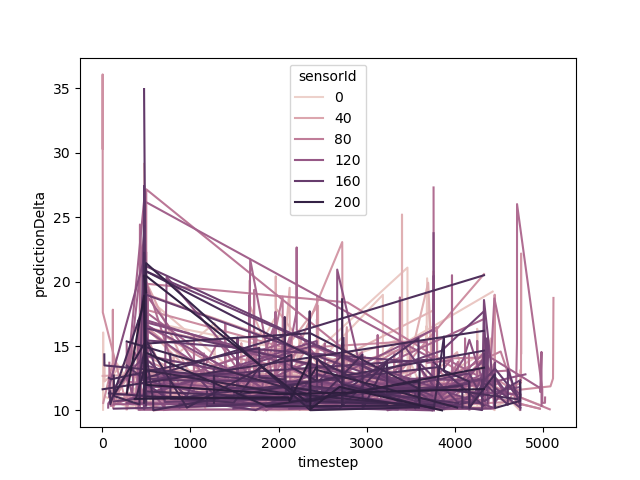

In [16]:
plt.close()

high_delta_threshold = 10  # IF WE CONSIDER 10 mile/h TO BE HIGH ERROR
high_delta = df_long[df_long['predictionDelta'] > high_delta_threshold]

sns.lineplot(data=high_delta, x="timestep", y="predictionDelta", hue="sensorId")

<Axes: xlabel='sensorId'>

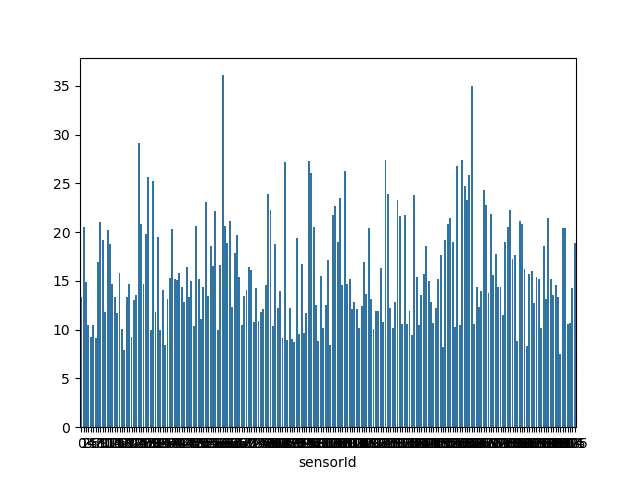

In [17]:
plt.close()

max_errors = df_long.groupby('sensorId')['predictionDelta'].max()

# Plotting max errors for each sensor
sns.barplot(x=max_errors.index, y=max_errors.values)

<Axes: xlabel='timestep', ylabel='predictionDelta'>

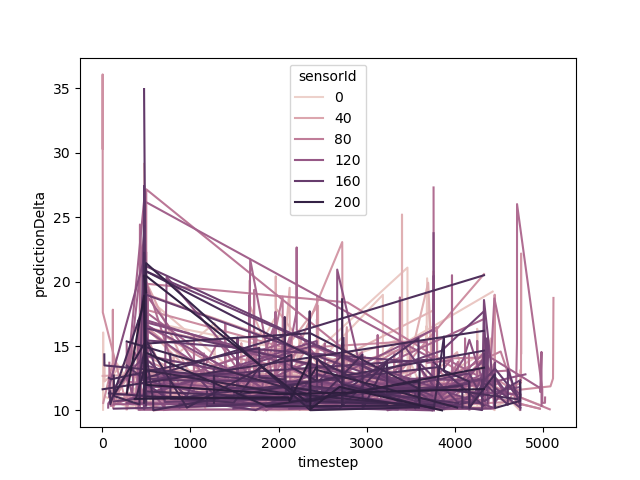

In [19]:
plt.close()

high_delta_threshold = 10

# Filter for high delta periods and find sensors with highest errors during those times
high_delta_periods = df_long[df_long['predictionDelta'] > high_delta_threshold]

# Group by timestep and sensorId to find max errors for those periods
high_delta_sensors = high_delta_periods.groupby(['timestep', 'sensorId'])['predictionDelta'].max()

# Plot
sns.lineplot(data=high_delta_sensors.reset_index(), x="timestep", y="predictionDelta", hue="sensorId")